# EDA and Feature Engineering

In [1]:
pip install utils

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from utils import (
    plot_gradient_bar,
    save_and_display,
    plot_gradient_bar_grouped,
    plot_woe_distribution_plotly,
    plot_stacked_categorical_gradient
)

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## 1. Reading file

In [59]:
import pandas as pd

path = "accepted_2007_to_2018Q4.csv"

# read tiny sample to inspect columns and initial dtypes
df = pd.read_csv(path, nrows=200)
print(df.shape)
print(df.dtypes)
print(df.columns.tolist())


(200, 151)
id                         int64
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt

In [60]:
df.shape

(200, 151)

In [61]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [62]:
# Define the mapping
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary'].value_counts()

loan_status_binary
1    168
0     32
Name: count, dtype: int64

In [63]:
df['loan_status_binary'].isnull().sum()

np.int64(0)

FileNotFoundError: No such file or directory: 'loan_default_distribution'

FileNotFoundError: No such file or directory: 'loan_default_distribution'

<IPython.core.display.Image object>

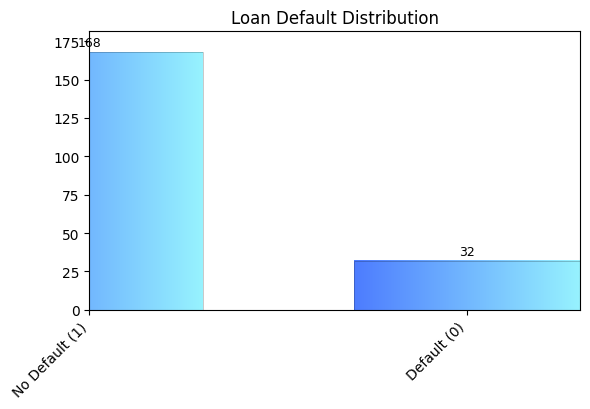

In [64]:
fig = plot_gradient_bar(
    labels=['No Default (1)', 'Default (0)'],
    values=[df['loan_status_binary'].value_counts()[1],
            df['loan_status_binary'].value_counts()[0]],
    title="Loan Default Distribution"
)

save_and_display(fig, "loan_default_distribution")


## 3. Missing values
> Check the missing values. columns that are missing by more than 50 percent will be removed.

In [65]:
def missing_data_summary(df, threshold=0):
    """
    Summarizes missing data, showing count and percentage of missing values for each column.
    Filters columns based on a missing percentage threshold.
    
    Parameters:
        df (pd.DataFrame): The dataframe to analyze.
        threshold (float): The minimum percentage of missing data to include in the summary.
    
    Returns:
        pd.DataFrame: A summary of missing data.
    """
    return (pd.DataFrame(df.isna().sum())
            .reset_index()
            .rename(columns={'index': 'Column', 0: 'mis_count'})
            .query('mis_count > 0')  # Only include columns with missing values
            .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
            .query(f'Missing_Percentage > {threshold}')  # Filter by threshold
            .sort_values('mis_count', ascending=False)
            .reset_index(drop=True))

missing = missing_data_summary(df,51)
missing

,Column,mis_count,Missing_Percentage
0,member_id,200,100.0
1,desc,200,100.0
2,revol_bal_joint,200,100.0
3,sec_app_num_rev_accts,200,100.0
4,sec_app_open_act_il,200,100.0
5,sec_app_revol_util,200,100.0
6,sec_app_open_acc,200,100.0
7,sec_app_mort_acc,200,100.0
8,sec_app_inq_last_6mths,200,100.0
9,sec_app_earliest_cr_line,200,100.0


In [66]:
# Convert the first column of 'missing' to a list
columns_to_drop = missing.iloc[:, 0].tolist()

# Drop these columns from the DataFrame 'df'
df = df.drop(columns=columns_to_drop, errors='ignore')  # 'errors="ignore"' ensures no error if a column is missing

In [67]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status_binary
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,Mar-2019,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,1
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,Mar-2019,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,1
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,Jun-2017,15813.30,Mar-2019,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,1
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,Feb-2019,829.90,Mar-2019,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0

## 4. Categorical Features

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 107 entries, id to loan_status_binary
dtypes: float64(83), int64(2), object(22)
memory usage: 167.3+ KB


In [69]:
df.select_dtypes(include=['object']).head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,Aug-2003,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,Dec-1999,w,Jun-2016,Mar-2019,Individual,N,Cash,N
2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,Aug-2000,w,Jun-2017,Mar-2019,Joint App,N,Cash,N
3,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,Sep-2008,w,Feb-2019,Mar-2019,Individual,N,Cash,N
4,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,Jun-1998,w,Jul-2016,Mar-2018,Individual,N,Cash,N


In [70]:
import numpy as np
import pandas as pd

# assume df already has the whitespace-trim step you ran:
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' else col)

# 1) Parse dates robustly ----------------------------------------------------
# - issue_d might be 'Dec-2015' or '2015-12-01' etc. Let pandas infer, coerce failures.
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce', dayfirst=False)

# earliest_cr_line, last_pymnt_d, last_credit_pull_d appear to be month-year like 'Dec-2015' or 'Dec-15'
# Use format='%b-%Y' but allow coercion so bad rows become NaT
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
df['last_pymnt_d']     = pd.to_datetime(df['last_pymnt_d'],     format='%b-%Y', errors='coerce')
df['last_credit_pull_d']= pd.to_datetime(df['last_credit_pull_d'],format='%b-%Y', errors='coerce')

# If some of these still come back NaT (because format differs), try a fallback inference:
for col in ['earliest_cr_line','last_pymnt_d','last_credit_pull_d']:
    if df[col].isna().any():
        df[col] = pd.to_datetime(df[col].astype(str).replace('nan',''), errors='coerce')

# quick check
print("Dates parsed: issue_d nnull =", df['issue_d'].notna().sum(),
      "; earliest_cr_line nnull =", df['earliest_cr_line'].notna().sum())

# 2) Percentage columns -> numeric -------------------------------------------
# Make sure columns exist and strip percent signs; coerce non-parsable values to NaN
if 'int_rate' in df.columns:
    df['int_rate%'] = pd.to_numeric(df['int_rate'].astype(str).str.replace('%','', regex=False), errors='coerce')
if 'revol_util' in df.columns:
    df['revol_util%'] = pd.to_numeric(df['revol_util'].astype(str).str.replace('%','', regex=False), errors='coerce')

# drop original columns only if present
columns_to_drop = {'title','zip_code','pymnt_plan','emp_title','int_rate','revol_util','url'}
existing_to_drop = [c for c in columns_to_drop if c in df.columns]
df.drop(existing_to_drop, axis=1, inplace=True)

# 3) debt_settlement_flag: map safely to 0/1 ----------------------------------
if 'debt_settlement_flag' in df.columns:
    # handle 'Y','N', np.nan, strings like 'NaN'
    df['debt_settlement_flag'] = df['debt_settlement_flag'].astype(str).str.upper().replace({'NAN':'N', 'NONE':'N'})
    df['debt_settlement_flag'] = df['debt_settlement_flag'].map({'Y':1, 'N':0})
    df['debt_settlement_flag'] = df['debt_settlement_flag'].fillna(0).astype(int)

# 4) term -> binary 36-month flag --------------------------------------------
if 'term' in df.columns:
    df['term_36_months'] = np.where(df['term'].astype(str).str.contains('36'), 1, 0)
    df.drop('term', axis=1, inplace=True)

# 5) emp_length -> numeric years ---------------------------------------------
# common formats: '10+ years', '< 1 year', '3 years', 'n/a', ''
if 'emp_length' in df.columns:
    emp = df['emp_length'].fillna('').astype(str).str.strip().str.lower()
    emp = emp.replace({'n/a':'', 'nan':''})
    # Normalize '< 1' to '0', '10+' to '10'
    emp = emp.str.replace(r'\+','', regex=True)
    emp = emp.str.replace(r'<\s*1', '0', regex=True)
    # Extract leading number if present
    emp_num = emp.str.extract(r'(\d+)')[0]
    df['emp_length'] = pd.to_numeric(emp_num, errors='coerce').astype('float')

# 6) hardship_flag -> normalize ------------------------------------------------
if 'hardship_flag' in df.columns:
    # There may be literal 'NaN' strings; normalize then fill missing
    df['hardship_flag'] = df['hardship_flag'].astype(str).str.upper().replace({'NAN':'N', 'NONE':'N'})
    df['hardship_flag'] = df['hardship_flag'].where(df['hardship_flag'].isin(['Y','N']), 'N')
    # keep as 'Y'/'N' or convert to binary if needed:
    # df['hardship_flag_bin'] = df['hardship_flag'].map({'Y':1,'N':0}).astype(int)

# 7) optional: show a few diagnostics
print("loan_status_binary nulls:", df.get('loan_status_binary').isna().sum() if 'loan_status_binary' in df.columns else 'no column')
print("emp_length dtype, na count:", df['emp_length'].dtype, df['emp_length'].isna().sum() if 'emp_length' in df.columns else 'no column')
print("sample rows:")
display(df.head())


Dates parsed: issue_d nnull = 200 ; earliest_cr_line nnull = 200
loan_status_binary nulls: 0
emp_length dtype, na count: float64 9
sample rows:


,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status_binary,int_rate%,revol_util%,term_36_months
0,68407277,3600.0,3600.0,3600.0,123.03,C,C4,10.0,MORTGAGE,55000.0,Not Verified,2015-12-01,debt_consolidation,PA,5.91,0.0,2003-08-01,675.0,679.0,1.0,7.0,0.0,2765.0,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,2019-01-01,122.67,2019-03-01,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,0,1,13.99,29.7,1
1,68355089,24700.0,24700.0,24700.0,820.28,C,C1,10.0,MORTGAGE,65000.0,Not Verified,2015-12-01,small_business,SD,16.06,1.0,1999-12-01,715.0,719.0,4.0,22.0,0.0,21470.0,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,2016-06-01,926.35,2019-03-01,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,0,1,11.99,19.2,1
2,68341763,20000.0,20000.0,20000.0,432.66,B,B4,10.0,MORTGAGE,63000.0,Not Verified,2015-12-01,home_improvement,IL,10.78,0.0,2000-08-01,695.0,699.0,0.0,6.0,0.0,7869.0,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,2017-06-01,15813.30,2019-03-01,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,0,1,10.78,56.2,0
3,66310712,35000.0,35000.0,35000.0,829.90,C,C5,10.0,MORTGAGE,110000.0,Source Verified,2015-12-01,debt_consolidation,NJ,17.06,0.0,2008-09-01,785.0,789.0,0.0,13.0,0.0,7802.0,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,2019-02-01,829.90,2019-03-01,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,0,1,14.85,11.6,0
4,68476807,10400.0,10400.0,10400.0,289.91,F,F1,3.0,MORTGAGE,104433.0,Source Verified,2015-12-01,major_purchase,PA,25.37,1.0,1998-06-01,695.0,699.0,3.0,12.0,0.0,21929.0,35.0,w,0.00,0.00,11740.

In [71]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan_status_binary,int_rate%,revol_util%,term_36_months
0,68407277,3600.0,3600.0,3600.0,123.03,C,C4,10.0,MORTGAGE,55000.0,Not Verified,2015-12-01,debt_consolidation,PA,5.91,0.0,2003-08-01,675.0,679.0,1.0,7.0,0.0,2765.0,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,2019-01-01,122.67,2019-03-01,564.0,560.0,0.0,1.0,Individual,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,0,1,13.99,29.7,1
1,68355089,24700.0,24700.0,24700.0,820.28,C,C1,10.0,MORTGAGE,65000.0,Not Verified,2015-12-01,small_business,SD,16.06,1.0,1999-12-01,715.0,719.0,4.0,22.0,0.0,21470.0,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,2016-06-01,926.35,2019-03-01,699.0,695.0,0.0,1.0,Individual,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,0,1,11.99,19.2,1
2,68341763,20000.0,20000.0,20000.0,432.66,B,B4,10.0,MORTGAGE,63000.0,Not Verified,2015-12-01,home_improvement,IL,10.78,0.0,2000-08-01,695.0,699.0,0.0,6.0,0.0,7869.0,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,2017-06-01,15813.30,2019-03-01,704.0,700.0,0.0,1.0,Joint App,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,0,1,10.78,56.2,0
3,66310712,35000.0,35000.0,35000.0,829.90,C,C5,10.0,MORTGAGE,110000.0,Source Verified,2015-12-01,debt_consolidation,NJ,17.06,0.0,2008-09-01,785.0,789.0,0.0,13.0,0.0,7802.0,17.0,w,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,2019-02-01,829.90,2019-03-01,679.0,675.0,0.0,1.0,Individual,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,N,Cash,0,1,14.85,11.6,0
4,68476807,10400.0,10400.0,10400.0,289.91,F,F1,3.0,MORTGAGE,104433.0,Source Verified,2015-12-01,major_purchase,PA,25.37,1.0,1998-06-01,695.0,699.0,3.0,12.0,0.0,21929.0,35.0,w,0.00,0.00,11740.

In [72]:
def get_sorted_unique_counts(df):
    # Select columns with categorical data
    object_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Get the number of unique entries in each categorical column
    object_nunique = {col: df[col].nunique() for col in object_cols}
    
    # Convert to DataFrame and sort by unique counts
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
    unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)
    
    return unique_counts

get_sorted_unique_counts(df)

,Column,Unique Count
0,disbursement_method,1
1,hardship_flag,1
2,initial_list_status,2
3,application_type,2
4,verification_status,3
5,home_ownership,3
6,grade,6
7,purpose,10
8,sub_grade,29
9,addr_state,41


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

def _make_gradient_rect(ax, xleft, xright, ybottom, ytop, start_color, end_color, zorder=1):
    """
    Draw a vertical gradient rectangle by creating a custom colormap and imshow patch.
    """
    n = 256
    gradient = np.linspace(0, 1, n).reshape(1, n)
    cmap = LinearSegmentedColormap.from_list("grad", [start_color, end_color])
    # extent: left, right, bottom, top
    ax.imshow(gradient, aspect='auto', cmap=cmap, extent=(xleft, xright, ybottom, ytop), zorder=zorder)

def plot_gradient_bar(
    labels,
    values,
    gradients=None,
    title=None,
    bar_width=0.6,
    height=420,
    figsize=None,
    xlabel=None,
    ylabel=None,
    rotation=45,
    show_values=True,
    value_format="{:,}"
):
    """
    Draw vertical bars with vertical gradients.

    Parameters
    ----------
    labels : list[str]
    values : list[float]
    gradients : list[ (start_color, end_color) ] or single tuple
        Colors can be hex strings or matplotlib color names.
    title : str
    bar_width : float, width of each bar
    height : int, approximate pixel height (used to compute figsize if figsize not given)
    figsize : tuple (w,h) in inches; optional. If None, computed from number of labels.
    rotation : x tick label rotation in degrees
    show_values : bool, display numeric value above bars
    value_format : str format for values (supports format spec like "{:,}" or "{:.2f}")
    """
    # Basic validation
    if len(labels) != len(values):
        raise ValueError("labels and values must have same length")
    n = len(labels)

    # Normalize gradients input
    if gradients is None:
        gradients = [("#4d7cfe", "#97f3ff")] * n
    elif isinstance(gradients, (tuple, list)) and len(gradients) == 2 and isinstance(gradients[0], str):
        # single tuple provided like ('#a','#b')
        gradients = [gradients] * n
    elif len(gradients) != n:
        raise ValueError("Length of gradients must be 1 or equal to number of labels")

    # compute figsize if not provided
    if figsize is None:
        # width depends on number of bars, keep bars readable
        width_inch = max(6, min(0.5 * n + 2, 30))
        # height param is in pixels; convert to inches at 100 dpi
        height_inch = max(4, height / 100.0)
        figsize = (width_inch, height_inch)

    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    x = np.arange(n)
    maxh = max(values) if n else 1
    # draw gradient rectangles first
    for i, (lab, val) in enumerate(zip(labels, values)):
        left = i - bar_width/2
        right = i + bar_width/2
        # draw gradient from bottom (0) to top (val)
        start_color, end_color = gradients[i]
        _make_gradient_rect(ax, left, right, 0, val, start_color, end_color, zorder=1)
        # add a faint edge rectangle for crispness (transparent face)
        rect = Rectangle((left, 0), bar_width, val, fill=False, linewidth=0.6, edgecolor='black', zorder=2, alpha=0.25)
        ax.add_patch(rect)

        if show_values:
            try:
                txt = value_format.format(val)
            except Exception:
                txt = str(val)
            ax.text(i, val + maxh*0.01, txt, ha='center', va='bottom', fontsize=9, rotation=0)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rotation, ha='right')
    ax.set_ylim(0, maxh * 1.08)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    plt.tight_layout()
    return fig


FileNotFoundError: No such file or directory: 'Number of Unique Categories in Categorical Variables'

FileNotFoundError: No such file or directory: 'Number of Unique Categories in Categorical Variables'

<IPython.core.display.Image object>

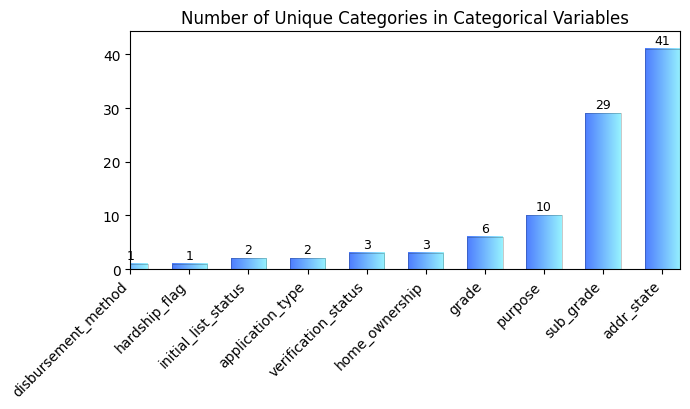

In [74]:

unique_counts = get_sorted_unique_counts(df)
labels = unique_counts["Column"].tolist()
values = unique_counts["Unique Count"].tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)


fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Number of Unique Categories in Categorical Variables",
    bar_width=0.6,
    height=420
)
save_and_display(fig, "Number of Unique Categories in Categorical Variables")


FileNotFoundError: No such file or directory: 'distribution_purpose'

FileNotFoundError: No such file or directory: 'distribution_purpose'

<IPython.core.display.Image object>

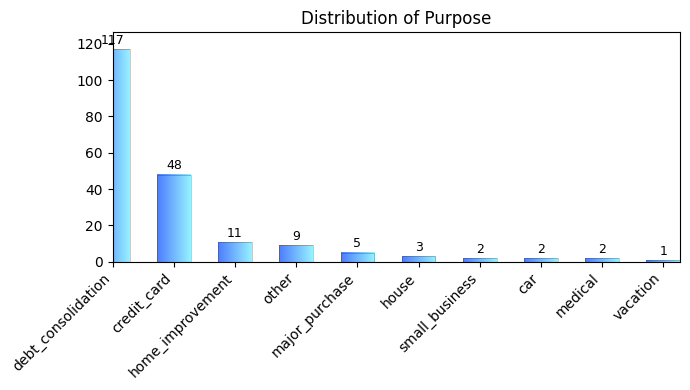

In [75]:
# PURPOSE
value_counts = df["purpose"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Purpose",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_purpose")


FileNotFoundError: No such file or directory: 'distribution_home_ownership'

FileNotFoundError: No such file or directory: 'distribution_home_ownership'

<IPython.core.display.Image object>

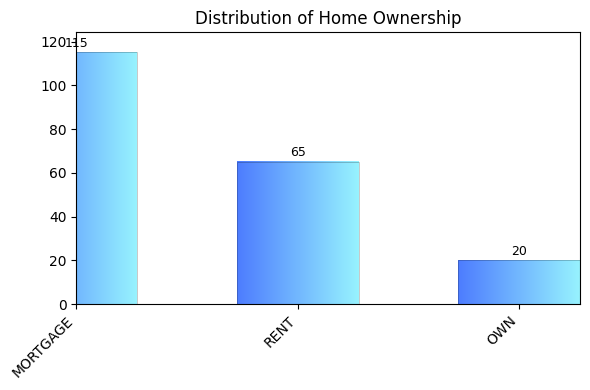

In [76]:
# HOME_OWNERSHIP
value_counts = df["home_ownership"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Home Ownership",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_home_ownership")


FileNotFoundError: No such file or directory: 'distribution_application_type'

FileNotFoundError: No such file or directory: 'distribution_application_type'

<IPython.core.display.Image object>

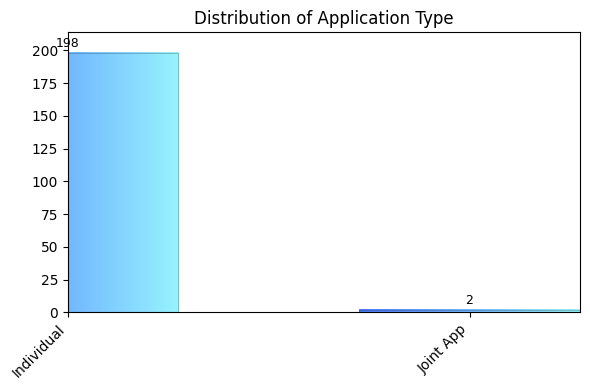

In [77]:
# APPLICATION_TYPE
value_counts = df["application_type"].value_counts(dropna=False).sort_values(ascending=False)
labels = value_counts.index.astype(str).tolist()
values = value_counts.values.tolist()
gradients = [("#4d7cfe", "#97f3ff")] * len(labels)

fig = plot_gradient_bar(
    labels=labels,
    values=values,
    gradients=gradients,
    title="Distribution of Application Type",
    bar_width=0.55,
    height=400
)
save_and_display(fig, "distribution_application_type")


In [78]:
def value_counter(df):
    value_series = pd.DataFrame()
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts(dropna = False))

value_counter(df)

grade
C    64
B    54
A    36
D    30
E    11
F     5
Name: count, dtype: int64
sub_grade
C2    15
C3    14
C4    14
A1    13
B4    11
B5    11
B1    11
B3    11
C5    11
B2    10
D1    10
A4    10
C1    10
A5     7
D3     7
A2     5
D2     5
D5     4
D4     4
E3     4
E4     3
E2     2
F1     2
F3     1
F2     1
E1     1
F5     1
E5     1
A3     1
Name: count, dtype: int64
home_ownership
MORTGAGE    115
RENT         65
OWN          20
Name: count, dtype: int64
verification_status
Not Verified       125
Source Verified     52
Verified            23
Name: count, dtype: int64
purpose
debt_consolidation    117
credit_card            48
home_improvement       11
other                   9
major_purchase          5
house                   3
small_business          2
car                     2
medical                 2
vacation                1
Name: count, dtype: int64
addr_state
NY    17
CA    16
OH    15
FL    15
TX    13
VA    10
MD     9
IN     8
PA     6
AL     5
MI     5
MA     5
SC    

###  Key Observations on Categorical Variables

>  **`sub_grade`** is already hierarchically grouped via `grade`, so it may be redundant in modeling.
>
> **`home_ownership`** shows strong imbalance: `MORTGAGE` and `RENT` dominate, while `OWN` and especially `OTHER` are underrepresented. This can lead to **bias in classification models**, favoring majority classes. Consider combining sparse categories.
>
>  **`purpose`** has several rarely used categories such as `medical`, `vacation`, `wedding`, `renewable_energy`, and `educational`. These low-frequency classes might **increase model variance** and can be safely grouped under `"other"`./
>
>  **`addr_state`** has 51 unique values and might be too granular for most models. Possible actions:
>
> * Grouping by **US regions**
> * Creating **risk-level clusters**
> * Dropping if uninformative


In [79]:
df.drop('sub_grade', axis=1, inplace = True) 

# Using WoE & IV for categorical features
>Now we will group categorical data based on Weight of Evidence (WoE) and create a table with relevant measures.
> **WoE**: WoE is computed as:<br>
> "Non-Event" - bad = '0' defaulted loans, <br>
> "Event"     - good = '1' non-default loans.<br>

$$
\text{WoE} = \ln\left(\frac{\text{Proportion of Non-Event}}{\text{Proportion of Event}}\right)
$$


> **IV (Information Value)** indicates the predictive power of the categorical variable. Total IV: Interpret the IV to understand the variable's predictive strength.

$$
\text{IV} = \sum \left( (\text{Proportion of Non-Event} - \text{Proportion of Event}) \cdot \text{WoE} \right)
$$

>Interpretation of IV:<br>
> < 0.02: Not Predictive <br>
> 0.02 - 0.1: Weak Predictive Power<br>
> 0.1 - 0.3: Medium Predictive Power<br>
> 0.3+: Strong Predictive Power<br>
> IV > 0.5: Suspiciously strong — Could indicate overfitting or data issues.

In [80]:
def process_categorical_columns(df, categorical_cols, target_col, woe_table=None, iv_summary=None, append=False):
    """
    Calculate WoE and IV for given categorical columns, including NaNs as a separate category.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        categorical_cols (list): List of categorical column names to process.
        target_col (str): Name of the binary target column (1 = Good, 0 = Bad).
        woe_table (pd.DataFrame): Existing WoE table (required if append=True).
        iv_summary (pd.DataFrame): Existing IV summary (required if append=True).
        append (bool): If True, append results to existing tables.
    
    Returns:
        woe_table (pd.DataFrame): WoE table with all processed columns.
        iv_summary (pd.DataFrame): IV summary table with all processed columns.
    """
    if append and (woe_table is None or iv_summary is None):
        raise ValueError("Existing tables must be provided when append=True.")
    
    # Initialize results if not appending
    if not append:
        woe_table = pd.DataFrame()
        iv_summary = pd.DataFrame()
    
    new_woe_results = []
    new_summary = []

    # Process each categorical column
    for col in categorical_cols:
        # Handle NaN values by creating a separate 'NaN' category
        df[col] = df[col].fillna('NaN')
        
        # Group by the column to calculate metrics
        stats = df.groupby(col).agg(
            event_count=(target_col, 'sum'),
            total_count=(target_col, 'count')
        ).reset_index()

        # Calculate non-event count and proportions
        stats['non_event_count'] = stats['total_count'] - stats['event_count']
        total_events = stats['event_count'].sum()
        total_non_events = stats['non_event_count'].sum()

        # Avoid division by zero
        stats['event_rate'] = stats['event_count'] / (total_events + 1e-6)
        stats['non_event_rate'] = stats['non_event_count'] / (total_non_events + 1e-6)

        # Calculate WoE
        stats['woe'] = np.log((stats['non_event_rate'] + 1e-6) / (stats['event_rate'] + 1e-6))
        
        # Calculate IV for each category
        stats['iv'] = (stats['non_event_rate'] - stats['event_rate']) * stats['woe']
        
        # Compute total IV for the column
        total_iv = stats['iv'].sum()

        # Add column name and rename for desired format
        stats['name'] = col  # Add column name
        stats.rename(columns={col: 'sub_name'}, inplace=True)  # Rename column to 'sub_name'
        
        # Reorder columns
        stats = stats[['name', 'sub_name', 'event_count', 'total_count', 'non_event_count', 
                       'event_rate', 'non_event_rate', 'woe', 'iv']]

        # Append results
        new_woe_results.append(stats)
        new_summary.append({'Column': col, 'IV': total_iv})

    # Combine results with existing tables if appending
    new_woe_table = pd.concat(new_woe_results, ignore_index=True)
    new_iv_summary = pd.DataFrame(new_summary).sort_values(by='IV', ascending=False)

    if append:
        woe_table = pd.concat([woe_table, new_woe_table], ignore_index=True)
        iv_summary = pd.concat([iv_summary, new_iv_summary], ignore_index=True).sort_values(by='IV', ascending=False)
    else:
        woe_table = new_woe_table
        iv_summary = new_iv_summary

    return woe_table, iv_summary

In [81]:
# Initial processing
categorical_cols = df.select_dtypes(include=['object']).columns
woe_table, iv_summary = process_categorical_columns(df, categorical_cols, 'loan_status_binary')

# Save initial results
# woe_table.to_csv('woe_table.csv', index=False)
# iv_summary.to_csv('iv_summary.csv', index=False)

iv_summary

,Column,IV
4,addr_state,4.710523e+00
0,grade,1.356866e+00
3,purpose,1.010727e+00
6,application_type,1.118661e-01
1,home_ownership,6.461315e-02
5,initial_list_status,1.255121e-02
2,verification_status,8.768260e-03
7,hardship_flag,6.399688e-16
8,disbursement_method,6.399688e-16


In [82]:
woe_table['name'].unique()

array(['grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type',
       'hardship_flag', 'disbursement_method'], dtype=object)

In [83]:
 #dropping where IV < 0.02
drop= {'application_type','initial_list_status','addr_state','purpose'}
df.drop(drop, axis=1, inplace=True)

In [84]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'hardship_flag']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
67,hardship_flag,N,168,200,32,1.0,1.0,-2.529759e-08,6.399688e-16


In [85]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'verification_status']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
9,verification_status,Not Verified,104,125,21,0.619048,0.65625,0.058359,0.002171
10,verification_status,Source Verified,44,52,8,0.261905,0.25000,-0.046520,0.000554
11,verification_status,Verified,20,23,3,0.119048,0.09375,-0.238890,0.006043


In [86]:
print("Initial WoE Table:")
woe_table[woe_table.name == 'home_ownership']

Initial WoE Table:


,name,sub_name,event_count,total_count,non_event_count,event_rate,non_event_rate,woe,iv
6,home_ownership,MORTGAGE,100,115,15,0.595238,0.46875,-0.238891,0.030217
7,home_ownership,OWN,16,20,4,0.095238,0.12500,0.271931,0.008093
8,home_ownership,RENT,52,65,13,0.309524,0.40625,0.271933,0.026303


> As we see the WoE, IV and total counts numbers we can group the 'ANY', 'MORTGAGE' and 'NONE' together.

In [87]:
home_ownership_mapping = {
    'ANY' : 'other',
    'MORTGAGE' : 'other',
    'RENT' : 'rent',
    'OWN' : 'own',
    'NONE' : 'other'
}
df.home_ownership = df.home_ownership.map(home_ownership_mapping)
df.home_ownership

0      other
1      other
2      other
3      other
4      other
       ...  
195     rent
196    other
197     rent
198    other
199    other
Name: home_ownership, Length: 200, dtype: object

### 📊 Checking categorical features vs target

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_stacked_categorical_gradient(
    df,
    col,
    target_col="loan_status_binary",
    title=None,
    bar_width=0.6,
    height=400,
    colors=("royalblue", "tomato"),
    figsize=None
):
    """
    Draws a stacked bar chart showing distribution of target (default vs non-default)
    across categories of a given categorical column, with gradient effect.
    """
    grouped = df.groupby([col, target_col]).size().unstack(fill_value=0)
    grouped = grouped.reindex(grouped.sum(axis=1).sort_values(ascending=False).index)

    proportions = grouped.div(grouped.sum(axis=1), axis=0)
    labels = proportions.index
    x = np.arange(len(labels))

    if figsize is None:
        figsize = (max(6, len(labels) * 0.6), height / 100.0)

    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    bottom = np.zeros(len(labels))

    for i, cls in enumerate(proportions.columns):
        ax.bar(
            x,
            proportions[cls],
            bottom=bottom,
            width=bar_width,
            color=colors[i % len(colors)],
            edgecolor="white",
            label=f"{cls} (loan_status_binary)"
        )
        bottom += proportions[cls]

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    if title:
        ax.set_title(title)
    ax.legend(title="Default Status", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    return fig


FileNotFoundError: No such file or directory: 'stacked_grade'

FileNotFoundError: No such file or directory: 'stacked_grade'

<IPython.core.display.Image object>

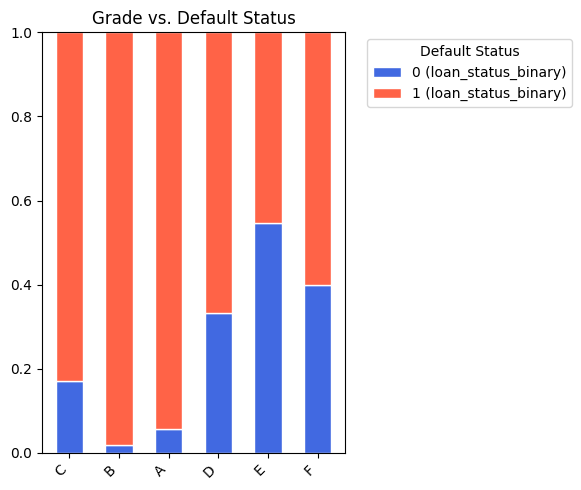

In [89]:
# GRADE
fig = plot_stacked_categorical_gradient(
    df,
    col="grade",
    title="Grade vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_grade")


FileNotFoundError: No such file or directory: 'stacked_hardship_flag'

FileNotFoundError: No such file or directory: 'stacked_hardship_flag'

<IPython.core.display.Image object>

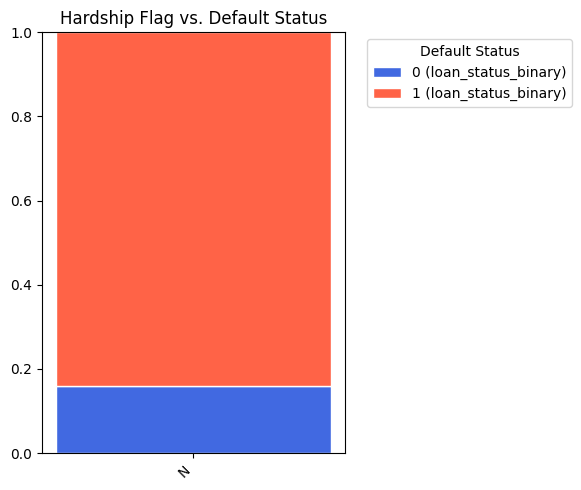

In [90]:
# HARDSHIP_FLAG
fig = plot_stacked_categorical_gradient(
    df,
    col="hardship_flag",
    title="Hardship Flag vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_hardship_flag")


FileNotFoundError: No such file or directory: 'stacked_verification_status'

FileNotFoundError: No such file or directory: 'stacked_verification_status'

<IPython.core.display.Image object>

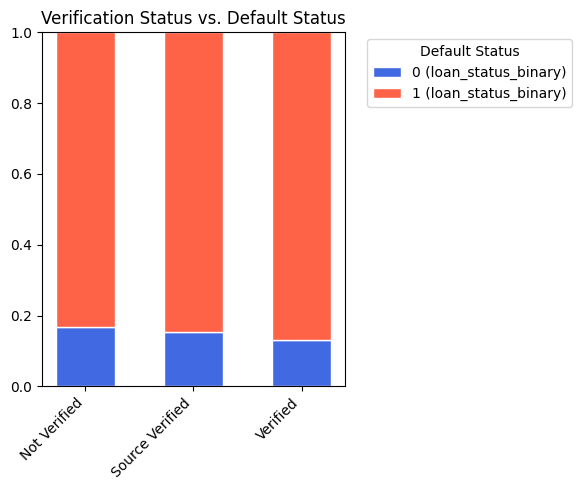

In [91]:
# VERIFICATION_STATUS
fig = plot_stacked_categorical_gradient(
    df,
    col="verification_status",
    title="Verification Status vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_verification_status")


FileNotFoundError: No such file or directory: 'stacked_home_ownership'

FileNotFoundError: No such file or directory: 'stacked_home_ownership'

<IPython.core.display.Image object>

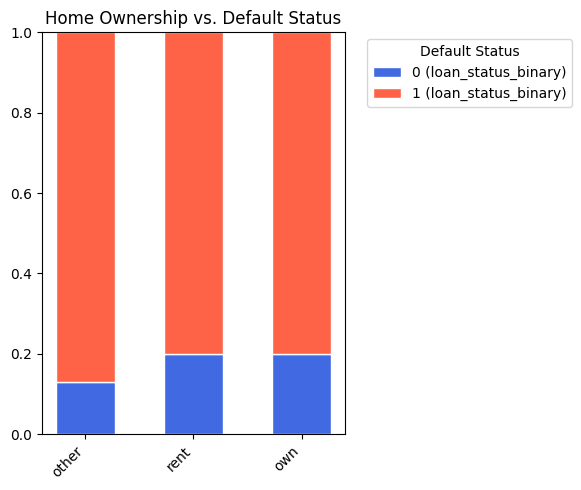

In [92]:
# HOME_OWNERSHIP
fig = plot_stacked_categorical_gradient(
    df,
    col="home_ownership",
    title="Home Ownership vs. Default Status",
    bar_width=0.55,
    height=500
)
save_and_display(fig, "stacked_home_ownership")


## 5. Date features

>Date columns often contain valuable temporal information that can improve predictive modeling. Lets extract meaningful features from these date columns.



In [93]:
date_cols = df.select_dtypes(include=['datetime64']).columns
df[date_cols].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2015-12-01,2003-08-01,2019-01-01,2019-03-01
1,2015-12-01,1999-12-01,2016-06-01,2019-03-01
2,2015-12-01,2000-08-01,2017-06-01,2019-03-01
3,2015-12-01,2008-09-01,2019-02-01,2019-03-01
4,2015-12-01,1998-06-01,2016-07-01,2018-03-01


In [94]:
df[date_cols].isna().sum()

issue_d               0
earliest_cr_line      0
last_pymnt_d          0
last_credit_pull_d    0
dtype: int64

In [95]:
from datetime import datetime

# Assuming 'today' as the current date
today = pd.to_datetime("today")

#impute a today date to distinguish missing values.
df['last_pymnt_d'].fillna(today, inplace=True)
df['last_credit_pull_d'].fillna(today, inplace=True)

# Time differences
df['loan_age'] = (today - df['issue_d']).dt.days
df['credit_history_length'] = (df['issue_d'] - df['earliest_cr_line']).dt.days
df['time_since_last_payment'] = (today - df['last_pymnt_d']).dt.days
df['time_since_last_credit_pull'] = (today - df['last_credit_pull_d']).dt.days

# Temporal components
df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month

# Categorical flags
df['recent_payment'] = (df['time_since_last_payment'] <= 30).astype(int)
df['recent_credit_pull'] = (df['time_since_last_credit_pull'] <= 90).astype(int)

drop = {'issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d'}
df.drop(drop,axis=1, inplace=True)

## 6. Numeric Features

In [96]:
y = df.loan_status_binary
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).drop('loan_status_binary',axis=1).columns

# Concatenate numeric columns explicitly
df_final = pd.concat([df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True)], axis=1)
# print(df_final.shape)
# df_final.head()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Columns: 104 entries, id to verification_status_Verified
dtypes: bool(9), float64(84), int32(2), int64(9)
memory usage: 148.8 KB


In [97]:
external_scores = {'last_fico_range_high','last_fico_range_low','fico_range_low', 'fico_range_high'}
df_final.drop(external_scores , axis=1, inplace=True)
df_final.drop('id', axis=1, inplace=True)

In [98]:
df_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,int_rate%,revol_util%,term_36_months,loan_age,credit_history_length,time_since_last_payment,time_since_last_credit_pull,issue_year,issue_month,recent_payment,recent_credit_pull,grade_B,grade_C,grade_D,grade_E,grade_F,home_ownership_own,home_ownership_rent,verification_status_Source Verified,verification_status_Verified
0,3600.0,3600.0,3600.0,123.03,10.0,55000.0,5.91,0.0,1.0,7.0,0.0,2765.0,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,0.0,1.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0,13.99,29.7,1,3616,4505,2489,2430,2015,12,0,0,False,True,False,False,False,False,False,False,False
1,24700.0,24700.0,24700.0,820.28,10.0,65000.0,16.06,1.0,4.0,22.0,0.0,21470.0,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,0.0,1.0,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0,11.99,19.2,1,3616,5844,3433,2430,2015,12,0,0,False,True,False,False,False,False,False,False,False
2,20000.0,20000.0,20000.0,432.66,10.0,63000.0,10.78,0.0,0.0,6.0,0.0,7869.0,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,0.0,1.0,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,0,10.78,56.2,0,3616,5600,3068,2430,2015,12,0,0,True,False,False,False,False,False,False,False,False
3,35000.0,35000.0,35000.0,829.90,10.0,110000.0,17.06,0.0,0.0,13.0,0.0,7802.0,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,0.0,1.0,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,NaN,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,0,14.85,11.6,0,3616,2647,2458,2430,2015,12,0,0,False,True,False,False,False,False,False,True,False
4,10400.0,10400.0,10400.0,289.91,3.0,104433.0,25.37,1.0,3.0,12.0,0.0,21929.0,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,0.0,1.0,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0,22.45,64.5,0,3616,63

In [99]:
from sklearn.impute import SimpleImputer

# Define imputer (mean for numeric features, most frequent for categorical)
imputer = SimpleImputer(strategy='mean')

# Apply imputation to X
X_imputed = imputer.fit_transform(df_final)

# Convert back to DataFrame if necessary
df_final = pd.DataFrame(X_imputed, columns=df_final.columns)


1. Correlation Analysis
Identify features strongly correlated with the target variable.

In [100]:
# Compute the absolute correlations
correlations = df_final.corrwith(y).abs()

# Convert to DataFrame and sort
correlation_df = correlations.sort_values(ascending=False).reset_index()
correlation_df.columns = ['name', 'correlation']

# Display the resulting DataFrame
correlation_df.head(30)

,name,correlation
0,recoveries,0.453414
1,collection_recovery_fee,0.453414
2,debt_settlement_flag,0.436365
3,total_rec_prncp,0.404745
4,int_rate%,0.373068
5,last_pymnt_amnt,0.293788
6,total_pymnt_inv,0.290308
7,total_pymnt,0.290308
8,total_rec_late_fee,0.275705
9,grade_E,0.253652


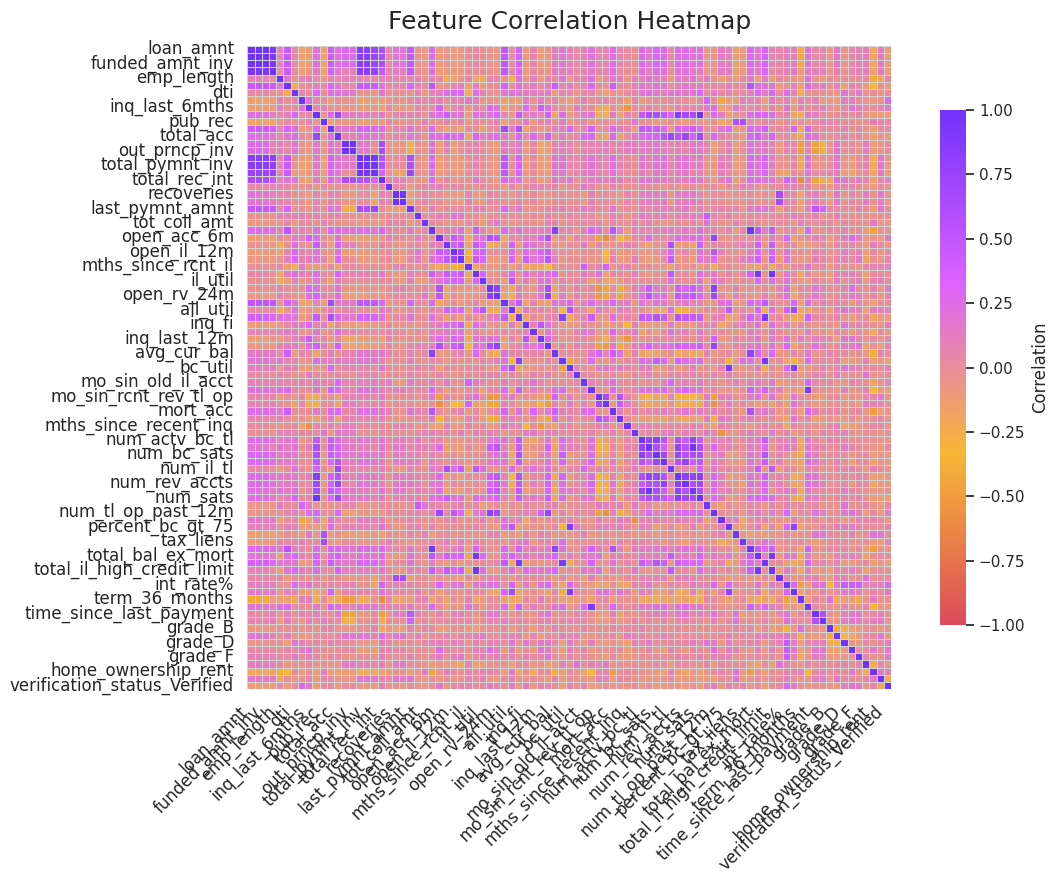

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


colors = ["#dc4b5b", "#f7b736", "#dd62ff", "#7132fb"]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)


feature_corr = df_final.corr()


mask = (feature_corr.abs() > 0.4).any(axis=1)
filtered_corr = feature_corr.loc[mask, mask]


plt.figure(figsize=(12, 9))
sns.set(font="DejaVu Sans", style="white", rc={"axes.facecolor": "white"})

sns.heatmap(
    filtered_corr,
    cmap=custom_cmap,
    center=0,
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    annot=False,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    vmin=-1, vmax=1
)

plt.title("Feature Correlation Heatmap", fontsize=18, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



>The heatmap above displays the most relevant correlations between features (|corr| > 0.4), allowing for better visibility and interpretability.


In [102]:
# Identify pairs of highly correlated features
threshold = 0.8
high_corr_pairs = feature_corr.abs().stack().reset_index()
high_corr_pairs = high_corr_pairs[high_corr_pairs['level_0'] != high_corr_pairs['level_1']]
high_corr_pairs = high_corr_pairs[high_corr_pairs[0] > threshold]
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs

,Feature1,Feature2,Correlation
1,loan_amnt,funded_amnt,1.000000
2,loan_amnt,funded_amnt_inv,1.000000
3,loan_amnt,installment,0.934140
15,loan_amnt,total_pymnt,0.856160
16,loan_amnt,total_pymnt_inv,0.856160
...,...,...,...
6362,total_bc_limit,bc_open_to_buy,0.921661
6439,total_il_high_credit_limit,total_bal_il,0.970798
6478,total_il_high_credit_limit,total_bal_ex_mort,0.928745
6719,revol_util%,bc_util,0.885046


# 📊Feature selection & training

> Highly correlated features can lead to redundancy, multicollinearity, and reduced model interpretability.
> We already checked correlation with target:  Pearson correlation with the target variable to rank features,correlation matrix heatmap. 
> There is a way to drop one feature from each highly correlated pair (e.g., |correlation| > 0.8) using domain knowledge.
> There is also an option to use Tree-Based Models for feature selection and rank features based on importance scores.

## 1. Selection based on correlation

In [103]:
# Create a set to store features to drop
features_to_drop = set()

# Iterate through each pair of highly correlated features
for _, row in high_corr_pairs.iterrows():
    feature1 = row['Feature1']
    feature2 = row['Feature2']
    
    # Get the correlation with the target for both features
    corr1 = correlation_df[correlation_df['name'] == feature1]['correlation'].values[0]
    corr2 = correlation_df[correlation_df['name'] == feature2]['correlation'].values[0]
    
    # Drop the feature with lower correlation with the target
    if corr1 >= corr2:
        features_to_drop.add(feature2)
    else:
        features_to_drop.add(feature1)

# Drop features from your dataset
selected_features = [col for col in feature_corr.columns if col not in features_to_drop]

# Print the results
print(f"Features to drop: {features_to_drop}")
print(f"Remaining features: {len(selected_features)}")

Features to drop: {'out_prncp', 'open_rv_12m', 'funded_amnt', 'tot_cur_bal', 'total_bc_limit', 'total_pymnt_inv', 'percent_bc_gt_75', 'funded_amnt_inv', 'num_bc_sats', 'total_pymnt', 'out_prncp_inv', 'total_il_high_credit_limit', 'collection_recovery_fee', 'total_rev_hi_lim', 'loan_amnt', 'num_sats', 'num_rev_tl_bal_gt_0', 'total_bal_ex_mort', 'mo_sin_old_rev_tl_op', 'bc_util', 'open_acc', 'installment', 'num_rev_accts'}
Remaining features: 76


> From highly correlated features  loan-amount and installment lets do a one new feature

In [104]:
df_final['loan_amnt_div_instlmnt']=df_final['loan_amnt']/df_final['installment']
df_final['loan_amnt_div_instlmnt'].head()

0    29.261156
1    30.111669
2    46.225674
3    42.173756
4    35.873202
Name: loan_amnt_div_instlmnt, dtype: float64

In [105]:
df_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,int_rate%,revol_util%,term_36_months,loan_age,credit_history_length,time_since_last_payment,time_since_last_credit_pull,issue_year,issue_month,recent_payment,recent_credit_pull,grade_B,grade_C,grade_D,grade_E,grade_F,home_ownership_own,home_ownership_rent,verification_status_Source Verified,verification_status_Verified,loan_amnt_div_instlmnt
0,3600.0,3600.0,3600.0,123.03,10.0,55000.0,5.91,0.0,1.0,7.0,0.0,2765.0,13.0,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,122.67,0.0,1.0,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,4.000000,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0.0,13.99,29.7,1.0,3616.0,4505.0,2489.0,2430.0,2015.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.261156
1,24700.0,24700.0,24700.0,820.28,10.0,65000.0,16.06,1.0,4.0,22.0,0.0,21470.0,38.0,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,926.35,0.0,1.0,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,0.000000,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0.0,11.99,19.2,1.0,3616.0,5844.0,3433.0,2430.0,2015.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.111669
2,20000.0,20000.0,20000.0,432.66,10.0,63000.0,10.78,0.0,0.0,6.0,0.0,7869.0,18.0,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.0,0.0,0.0,15813.30,0.0,1.0,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,10.000000,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,0.0,10.78,56.2,0.0,3616.0,5600.0,3068.0,2430.0,2015.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.225674
3,35000.0,35000.0,35000.0,829.90,10.0,110000.0,17.06,0.0,0.0,13.0,0.0,7802.0,17.0,15897.65,15897.65,31464.010000,31464.01,19102.35,12361.66,0.0,0.0,0.0,829.90,0.0,1.0,0.0,0.0,301500.0,1.0,1.0,0.0,1.0,23.0,12609.0,70.0,1.0,1.0,6987.0,45.0,67300.0,0.0,1.0,0.0,2.0,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,6.683333,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,0.0,14.85,11.6,0.0,3616.0,2647.0,2458.0,2430.0,2015.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.173756
4,10400.0,10400.0,10400.0,289.91,3.0,104433.0,25.37,1.0,3.0,12.0,0.0,21929.0,35.0,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.0,0.0,0.0,10128.96,0.0,1.0,0.0,0.0,331730.0,1.0,3.0,0.0,3.0,14.0,73839.0,84.0,4.0,7.0,9702.0,78.0,34000.0,2.0,1.0,3.0,10.0,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,1.000000,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19

In [106]:
drop={'funded_amnt_inv', 'total_bal_il', 'total_pymnt', 'num_rev_tl_bal_gt_0',
      'issue_year', 'num_sats', 'num_op_rev_tl', 'total_bc_limit', 
      'total_il_high_credit_limit', 'credit_history_length', 'num_bc_tl',
      'out_prncp_inv', 'num_tl_30dpd', 'bc_util', 'tot_cur_bal',
      'num_actv_bc_tl', 'open_acc', 'funded_amnt', 'loan_amnt',
      'installment','collection_recovery_fee', 'total_pymnt_inv', 
      'revol_bal', 'revol_util%', 'num_bc_sats'}
df_final.drop(drop,axis=1, inplace=True)

## 2. Further features selection with RFE

In [107]:
X = df_final

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
# Train Random Forest for feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Select features with importance above a threshold
model = SelectFromModel(rf, prefit=True, threshold="mean")
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

print(f"Original features: {X.shape[1]}, Selected features: {X_train_selected.shape[1]}")

# Get the mask of selected features
selected_features_mask = model.get_support()

# Get the names of the selected features
selected_features_names = np.array(X.columns)[selected_features_mask]
selected_features_names

Original features: 75, Selected features: 25


array(['dti', 'total_acc', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'tot_coll_amt', 'il_util', 'max_bal_bc', 'total_rev_hi_lim',
       'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'mo_sin_old_il_acct', 'mort_acc',
       'num_actv_rev_tl', 'num_rev_accts', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'debt_settlement_flag', 'int_rate%',
       'time_since_last_payment', 'loan_amnt_div_instlmnt'], dtype=object)

RESULT: 'out_prncp', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'debt_settlement_flag', 'int_rate%', 'loan_age',
       'time_since_last_payment', 'time_since_last_credit_pull',
       'loan_amnt_div_instlmnt'

# ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

ImportError: cannot import name 'numpy_compat' from 'tensorflow.python.util' (c:\Python312\Lib\site-packages\tensorflow\python\util\__init__.py)

In [109]:
X_train_final = X_train_selected
X_test_final = X_test_selected

# Define ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_final.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification (loan risk, churn, etc.)
])

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [111]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [112]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [113]:
history = model.fit(
    X_train_final, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.9882 - loss: 0.0477 - val_accuracy: 0.9946 - val_loss: 0.0230
Epoch 2/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.9940 - loss: 0.0257 - val_accuracy: 0.9954 - val_loss: 0.0206
Epoch 3/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9947 - loss: 0.0229 - val_accuracy: 0.9957 - val_loss: 0.0183
Epoch 4/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9950 - loss: 0.0217 - val_accuracy: 0.9965 - val_loss: 0.0167
Epoch 5/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9952 - loss: 0.0211 - val_accuracy: 0.9960 - val_loss: 0.0177
Epoch 6/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9953 - loss: 0.0211 - val_accuracy: 0.9960 - val_loss: 0.0178
Epoch 7/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9954 - loss: 0.0202 - val_accuracy: 0.9960 - val_loss: 0.0171
Epoch 8/50
40599/40599 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 

In [114]:
loss, acc = model.evaluate(X_test_final, y_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f}")

# Predict
y_pred = (model.predict(X_test_final) > 0.5).astype("int32")

✅ Test Accuracy: 0.9967
12688/12688 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


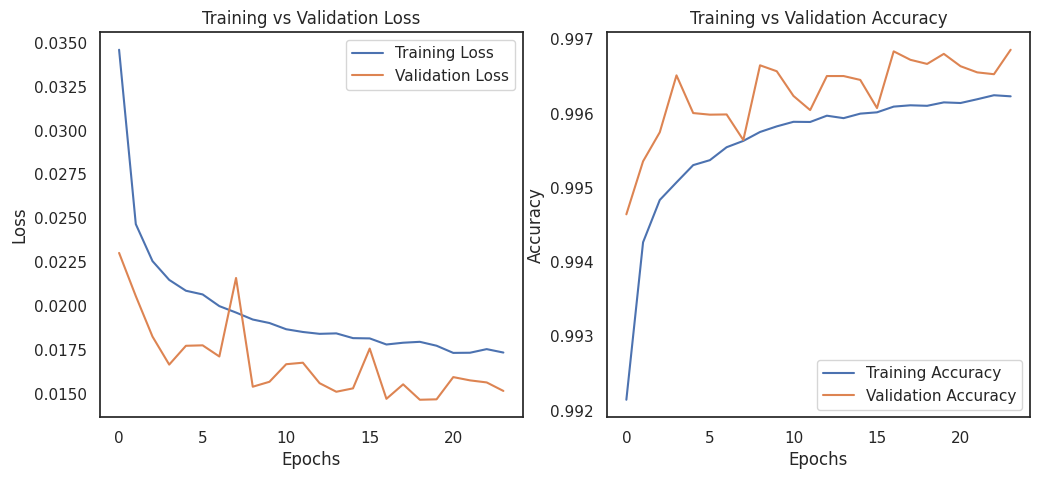

In [115]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12,5))

# ---- Loss ----
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# ---- Accuracy ----
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()

# Training Models 

##  1. Logistic Regression
##  2. Random Forest
##  3. Gradient Boost
##  4. Neural Networks

In [54]:
# Define a function to evaluate and display metrics
def evaluate_model(model, X_test, y_test, model_name):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {model_name}:")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC: {auc:.4f}")
    print("\n")
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F2": f2,
        "AUC": auc
    }

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, fbeta_score, roc_auc_score,
    classification_report, RocCurveDisplay)

# Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train)

# Random Forest Model
rf_soft = RandomForestClassifier(n_estimators=100, random_state=42)
rf_soft.fit(X_train_selected, y_train)

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_selected, y_train)

# Neural Network Model
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, random_state=42, solver='adam')
nn_model.fit(X_train_selected, y_train)

# Update the evaluation code to include all four models
results = []
results.append(evaluate_model(lr_model, X_test_selected, y_test, "Logistic Regression"))
results.append(evaluate_model(rf_soft, X_test_selected, y_test, "Random Forest"))
results.append(evaluate_model(gb_model, X_test_selected, y_test, "Gradient Boosting"))
results.append(evaluate_model(nn_model, X_test_selected, y_test, "Neural Network"))

# Plot ROC Curves for all models
plt.figure(figsize=(4, 4))
RocCurveDisplay.from_estimator(lr_model, X_test_selected, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf_soft, X_test_selected, y_test, name="Random Forest")
RocCurveDisplay.from_estimator(gb_model, X_test_selected, y_test, name="Gradient Boosting")
RocCurveDisplay.from_estimator(nn_model, X_test_selected, y_test, name="Neural Network")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

# Summarize the results in a DataFrame

results_df = pd.DataFrame(results)
print("Summary of Results:")
print(results_df)


# Conclusion
> The Neural Network and Random Forest model has quite good scores! We could check a different thresholds to see if the FP and FN can have a better results. Of course we need Logistic Regression due to interpretability.
> <br>
> In next notebook we will create a behavioral scorecard: the general framework involves setting score ranges and corresponding risk groups (e.g., high-risk, medium-risk, low-risk) based on statistical analysis and business policies.<br>
> To not interupt the code and make the steps clear I'm saving the important results:<br>
> * Logistic Regresion model - trade off between score and interpretability <br>
> * Neural Network  model<br>
> * Random Forest model<br>
> * data after cleaning with selected features.<br>
Everything here:<br>
https://www.kaggle.com/datasets/beatafaron/loan-credit-risk-and-population-stability


In [ ]:
## Save model for later use
import joblib  
# Save the NN model to a file
joblib.dump(nn_model, 'nn_model_model.pkl')

# Save the RF model to a file
joblib.dump(rf_soft, 'rf_soft_model.pkl')

# Save the LR model to a file
joblib.dump(lr_model, 'lr_model.pkl')

# Save df_final to a CSV file
df_final = df_final[selected_features_names]
df_final.to_csv("df_2014-18_selected.csv", index=False)